In [1]:
%matplotlib widget
from NPScattering2D import NanoparticleScattering2D
from ase.cluster import Decahedron,Icosahedron,Octahedron
from ase.io import write
import numpy as np
from debyecalculator import DebyeCalculator
from ase.visualize import view

### Test du code

On va comparer les intensités isotropes calculées par le code avec celles caluclées par DebyeCalculator

In [2]:
radius = 15
file = f'./structures/Sphere_{radius}.0.xyz'

# Définition de l'expérience
npix = 2000
distance = 0.36 # en m
wl = 1.54 # en \AA
pix_size= 0.00015


In [3]:
np_scatter = NanoparticleScattering2D(file, Distance= distance, wl= wl, npix= npix, pixel_size= pix_size)
print(f'La structure contient {np_scatter.nb_atoms} atomes')
q_dc, i_dc = np_scatter.compute_Iq_debyecalc()

----------------------------------------------------
 Configuration du détecteur / gamme Q accessible
----------------------------------------------------
 Longueur d'onde λ = 1.5400 Å
 Distance échantillon-détecteur = 360.00 mm
 Taille pixel = 0.150 mm
 Nombre de pixels = 2000 x 2000

 Gamme Qx : -1.5692 → 1.5679 Å⁻¹
 Gamme Qy : -0.5649 → 0.0000 Å⁻¹
 Gamme Qz : -1.5692 → 1.5679 Å⁻¹
 Module |Q| : 0.0000 → 2.1469 Å⁻¹
----------------------------------------------------

La structure contient 887 atomes


/home-local/ratel-ra/Documents/Python_code/Debye_3D/NPScattering2D.py:173: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled GPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc= DebyeCalculator(qmin=self.q_min,qmax=self.q_max,qstep=qstep,biso=0, device='cuda')


In [4]:
I_map=np_scatter.compute_intensity()

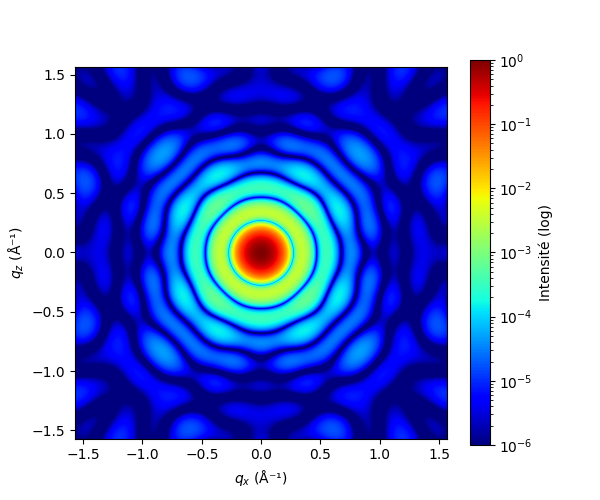

  File "/home-local/ratel-ra/Documents/Python_code/Debye_3D/NPScattering2D.py", line 305, in ai
    ai = AzimuthalIntegrator(dist=self.D, detector=detector)


In [5]:
np_scatter.plot_intensity(I_map,vmin=-6)
q,i=np_scatter.integrate_with_pyfai(I_map)
#qp,ip = np_scatter.integrate_with_pyfai(I_map)

## facteur de forme théorique

comparaison avec la solution analytique du facteur de forme d'une sphère

$I(q)= |N*f_0*F(q)|^2$ where $F(q)=3\frac{sin(qR)-qRcos(qR)}{(qR)^3}$

In [6]:
def saxs_sphere(q, R):
    qR = q * R
    # handle q=0 to avoid division by zero
    Fq = np.ones_like(qR)
    nonzero = qR != 0
    Fq[nonzero] = 3 * (np.sin(qR[nonzero]) - qR[nonzero] * np.cos(qR[nonzero])) / (qR[nonzero]**3)
    return Fq

def saxs_sphere_intensity(q, R):
    """
    Compute the SAXS intensity for a homogeneous sphere: I(q) = |f*F(q)|^2
    """
    Fq = saxs_sphere(q, R)
    return np.abs(Fq)**2*np_scatter.xray_f0(np_scatter.elements[0],q)**2*np_scatter.nb_atoms**2


/home-local/ratel-ra/Documents/Python_code/Debye_3D/NPScattering2D.py:173: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled GPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc= DebyeCalculator(qmin=self.q_min,qmax=self.q_max,qstep=qstep,biso=0, device='cuda')


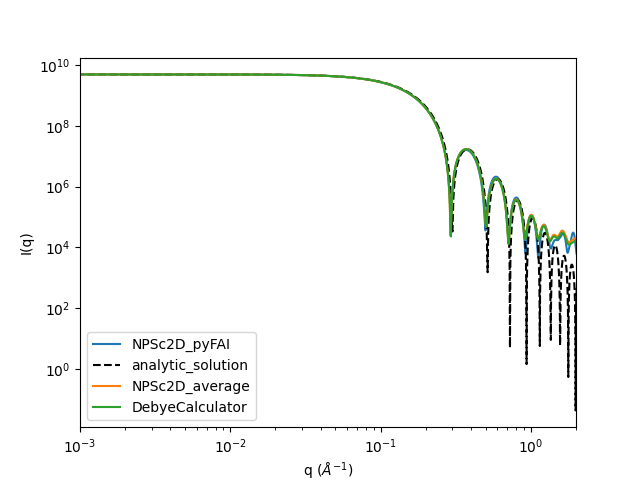

In [7]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sf
q_th = np.linspace(np_scatter.q_min,np_scatter.q_max,500)
i_th=saxs_sphere_intensity(q_th,radius)

q_iso, i_iso = np_scatter.compute_isotropic_intensity_fibonacci()
q_dc, i_dc = np_scatter.compute_Iq_debyecalc()

plt.figure()
#plt.loglog(q_dc, i_dc,label='DebyeCalculator')
plt.loglog(q,i,label='NPSc2D_pyFAI')
plt.loglog(q_th,i_th,'--k',label='analytic_solution')
plt.loglog(q_iso,i_iso,label='NPSc2D_average')
plt.loglog(q_dc, i_dc,label = 'DebyeCalculator')
plt.xlabel('q ($\AA^{-1}$)')
plt.xlim(0.001,2)
plt.ylabel('I(q)')
plt.legend()

### Essais avec des réseaux de particules

L'idée est de simuler des images SAXS/WAXS de réseaux de particules

#### Génération du réseau de particules

In [15]:
from generate_paracrystal_assembly import *
# assembalge orthorhomique face centrées, SG = Fddd #70 (Fmmm #69, Immm #71)
structure_file = generate_supercell([192.3,192.3, 252, 90,90,90], spacegroup=69, supercell_size=(10,20,10))

# par défaut la taille de la supermaille générée est 10*10*10 atomes

Supermaille générée : supercell.xyz (8000 atomes)


### Rotation de la structure pour passer en axe de zone [110]

In [16]:
np_scatter = NanoparticleScattering2D(structure_file, Distance= distance, wl= wl, npix= npix, pixel_size= pix_size)
np_scatter.positions = np_scatter.rotate_positions(45,0,0) # rotation du réseau pour passer en axe de zone 110
# Intensité pour orientation par défaut
I_stru = np_scatter.compute_intensity()



----------------------------------------------------
 Configuration du détecteur / gamme Q accessible
----------------------------------------------------
 Longueur d'onde λ = 1.5400 Å
 Distance échantillon-détecteur = 360.00 mm
 Taille pixel = 0.150 mm
 Nombre de pixels = 2000 x 2000

 Gamme Qx : -1.5692 → 1.5679 Å⁻¹
 Gamme Qy : -0.5649 → 0.0000 Å⁻¹
 Gamme Qz : -1.5692 → 1.5679 Å⁻¹
 Module |Q| : 0.0000 → 2.1469 Å⁻¹
----------------------------------------------------



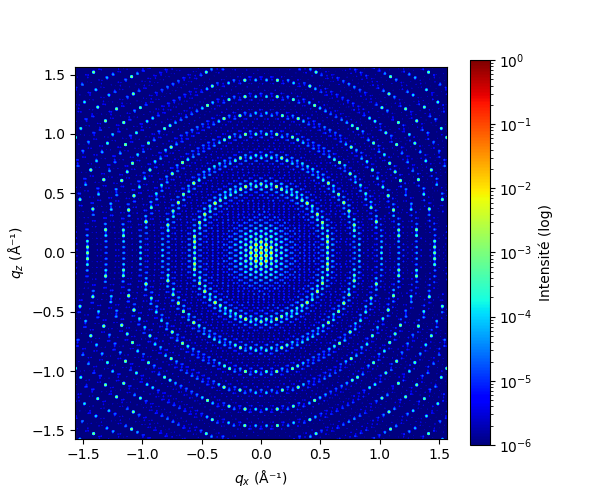

In [17]:
np_scatter.plot_intensity(I_stru,vmin=-6)

### Convolution Facteur de forme et facteur de structure

On fait les hypothèses suivantes:

- toutes nos nanoparticules ont la même orientation
- on retrouve une nanoparticule à chaque noeud du réseau cristallin

Dans le réseau réel, la structure est représentée par la convolution d'une particule par son réseau paracristallin

Dans le réseau réciproque, la particule donne le facteur de forme $P(q) = |N*f_0(q)*F(q)|^2$.

Dans le réseau réciproque, le réseau paracristallin donne $S(q)$

On peut alors calculer dans l'espace réciproque le signal obtenu par notre système comme étant:

$ I(q) = P(q)*S(q)$


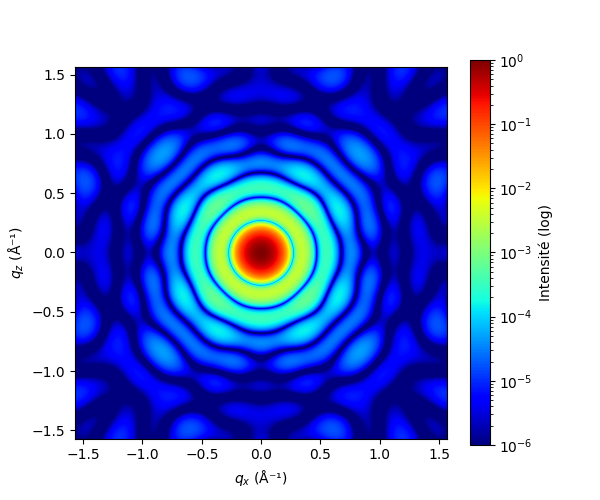

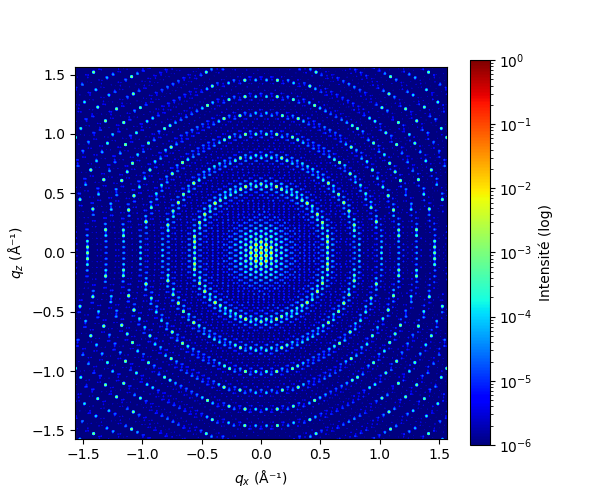

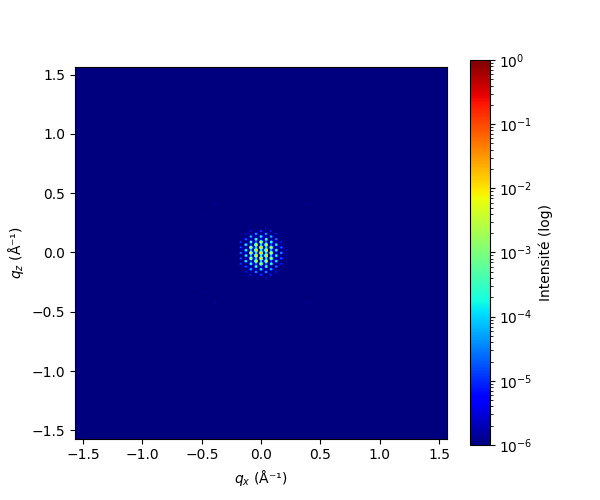

In [14]:
np_scatter.plot_intensity(I_map,vmin=-6)
np_scatter.plot_intensity(I_stru,vmin=-6)
np_scatter.plot_intensity(I_map*I_stru,vmin=-6)

## Essais avec des particules de forme cylindrique

In [12]:
r=15
l=75
file = f'./structures/ASE_cylinder_r=15_l=75.xyz'

# Calcul Debye 2D
np_scatter = NanoparticleScattering2D(file, Distance= distance, wl= wl, npix= npix, pixel_size= pix_size)
print(f'La structure contient {np_scatter.nb_atoms} atomes')
# my calc:
q, i = np_scatter.integrate_with_pyfai(np_scatter.compute_intensity())
# debyecalculator
q_dc,i_dc = np_scatter.compute_Iq_debyecalc()

# sasview
q_th = np.linspace(np_scatter.q_min,np_scatter.q_max,500)
i_th = cylinder_formfactor_norm(q_th,r,l)
#i_th *= np_scatter.xray_f0(np_scatter.elements[0],q_th)**2*np_scatter.nb_atoms**2



----------------------------------------------------
 Configuration du détecteur / gamme Q accessible
----------------------------------------------------
 Longueur d'onde λ = 1.5400 Å
 Distance échantillon-détecteur = 360.00 mm
 Taille pixel = 0.150 mm
 Nombre de pixels = 2000 x 2000

 Gamme Qx : -1.5692 → 1.5679 Å⁻¹
 Gamme Qy : -0.5649 → 0.0000 Å⁻¹
 Gamme Qz : -1.5692 → 1.5679 Å⁻¹
 Module |Q| : 0.0000 → 2.1469 Å⁻¹
----------------------------------------------------

La structure contient 4716 atomes


  File "/home-local/ratel-ra/Documents/Python_code/Debye_3D/NPScattering2D.py", line 325, in ai
    ai = AzimuthalIntegrator(dist=self.D, detector=detector)


OSError: Encountered invalid file format when trying to load structure from ./structures/ASE_cylinder_r=15_l=75.xyz

In [ ]:
f0_th = np_scatter.xray_f0(np_scatter.elements[0],q_th)
f0_dc = np_scatter.xray_f0(np_scatter.elements[0],q_dc)
plt.figure()
plt.loglog(q_dc, i_dc*f0_dc**2/np.max(i_dc*(f0_dc)**2),label='DebyeCalculator')
plt.loglog(q,i/np.max(i),label='NPScattering2D')
plt.loglog(q_th,i_th*f0_th**2/(np.max(f0_th)**2),'--k',label='sasview')
plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('I(q)')
plt.title ('Cylinder particle')
plt.legend()

### Cas de particules disques

In [ ]:
r=60
l=12
file = f'./structures/disk_r=60_L=12.xyz'

# Calcul Debye 2D
np_scatter = NanoparticleScattering2D(file, Distance= distance, wl= wl, npix= npix, pixel_size= pix_size)
print(f'La structure contient {np_scatter.nb_atoms} atomes')
I_map = np_scatter.compute_intensity()

q, i = np_scatter.integrate_intensity(I_map)

# debyecalculator
q_dc,i_dc=np_scatter.compute_Iq_debyecalc()

q_th = np.linspace(np_scatter.q_min,np_scatter.q_max,500)
i_th = cylinder_formfactor_norm(q_th,r,l)

In [ ]:
f0_th = np_scatter.xray_f0(np_scatter.elements[0],q_th)
f0_dc = np_scatter.xray_f0(np_scatter.elements[0],q_dc)
plt.figure()
plt.loglog(q_dc, i_dc*f0_dc**2/np.max(i_dc*(f0_dc)**2),label='DebyeCalculator')
plt.loglog(q,i/np.max(i),label='NPScattering2D')
plt.loglog(q_th,i_th*f0_th**2/(np.max(f0_th)**2),'--k',label='sasview')
plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('I(q)')
plt.title ('Disk particle')
plt.legend()

### Cas de lamelles empilées - 1 lamelle = réseau hexagonal 2D

a= 7.81nm, c= 69.8, 

In [ ]:
a = 78.1; c= 698
ratio = c/a
positions = generate_lattice_hex2d(a=a, nx=20, ny=20, nz=20, dz = ratio)
save_xyz(positions, filename='test.xyz')  # --> a réécrire!!

np_scatter = NanoparticleScattering2D('test.xyz', qmax=0.15, npix=256)
np_scatter.positions = np_scatter.rotate_positions(45,0,45)
# Intensité pour orientation par défaut
I_map = np_scatter.compute_intensity_parallel()

np_scatter.plot_intensity(I_map,vmin=-2)